## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
np.random.seed(42)
random.seed(42)

os.getcwd()

dataset_directory = './kaggledatasets'
dataset_dfs = {}

## Neural network model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

df_results = pd.read_csv('trainingData.csv')

tf.random.set_seed(42)

# Presortedness metrics for full array: 'Inversions', 'Deletions', 'Runs', 'Dis'
# Presortedness metrics for sample_size = 10 distributed sampling: 'Inversions_dist', 'Deletions_dist', 'Runs_dist', 'Dis_dist'
X = df_results[['deletions_val_dist13', 'runs_val_dist13']]

y = df_results['Algorithm']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# This split has been used to optimize a few parameters, can't be used to calculate final accuracy:
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train, X_split, y_train, y_split = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_split, y_split, test_size=0.5, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

# indices split
print(train_indices,test_indices)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# neural network

def create_model(layers, layersize):
    model = Sequential()
    model.add(Dense(layersize, input_dim=2, activation='relu'))
    for i in range(layers):
        model.add(Dense(layersize, activation='relu'))
        
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return model


param_grid = {
    'batch_size': [512],
    'epochs': [500],
    'layers': [0,1,2,3,4,5,6,7,8,9],
    'layersize': [1,2,3,4,5,6,7,8,9,10]
}

best_accuracy = 0
best_params = None

grid_results = []

# Perform grid search
for params in ParameterGrid(param_grid):
    print("Training model with params:", params)
    model = create_model(layers = params['layers'], layersize = params['layersize'])
    model.fit(X_train_scaled, y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0)
    y_pred = model.predict(X_val_scaled)
    accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)[1]
    grid_results.append({
        'Layers': params['layers'],
        'Layer Size': params['layersize'],
        'Accuracy': accuracy
    })
    print("Accuracy:", accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = model

df_grid_results = pd.DataFrame(grid_results)
df_grid_results_sorted = df_grid_results.sort_values(by='Accuracy', ascending=False)
print(df_grid_results_sorted)

# Print best parameters and accuracy
print("Best validation parameters:", best_params)
print("Best validation accuracy:", best_accuracy)
print("\n")

y_pred = best_model.predict(X_test_scaled)
baccuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print("Test Accuracy:", baccuracy)

2024-04-22 13:07:19.328591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 13:07:19.328661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 13:07:19.330019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 13:07:19.339155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 13:07:20.378595: W tensorflow/compiler/tf2

Index([1777,  579, 1228, 1800, 1840, 1756,  891,  836, 1192, 1689,
       ...
       1482,  330, 1238,  466, 2169, 1638, 1095, 1130, 1294,  860],
      dtype='int64', length=1575) Index([ 672,  809,  360, 1697, 2213, 1078, 1487,  480,   39, 1754,
       ...
       1208, 1808, 2080,  486, 2171,  948,  332, 2227, 2040,  771],
      dtype='int64', length=338)
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 1}


2024-04-22 13:07:21.496323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46873 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6
2024-04-22 13:07:21.497183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46873 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:a1:00.0, compute capability: 8.6
2024-04-22 13:07:22.931179: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fca94ef1de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 13:07:22.931233: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-22 13:07:22.931243: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
20

11/11 [==============================] - 0s 1ms/step
Accuracy: 0.639053225517273
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 2}
11/11 [==============================] - 0s 1ms/step
Accuracy: 0.7426035404205322
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 3}
11/11 [==============================] - 0s 1ms/step
Accuracy: 0.7514792680740356
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 4}
11/11 [==============================] - 0s 1ms/step
Accuracy: 0.7692307829856873
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 5}
11/11 [==============================] - 0s 1ms/step
Accuracy: 0.7514792680740356
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 6}
11/11 [==============================] - 0s 1ms/step
Accuracy: 0.7573964595794678
Training model with params: {'batch_size': 512, '

In [38]:
import pickle

# Save the dictionary to a file
with open('df_grid_results_dynamic.pkl', 'wb') as f:
    pickle.dump(df_grid_results, f)

## Results

In [40]:
# Make predictions on the test data and compare them to the True best Algorithm
y_pred = best_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
predicted_algorithms = label_encoder.inverse_transform(y_pred_classes)
true_algorithms = label_encoder.inverse_transform(y_test)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
comparison_df = pd.DataFrame({'Predicted Algorithm': predicted_algorithms, 'True Algorithm': true_algorithms})
display(comparison_df.head(50))

accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print("Test Accuracy:", baccuracy)

11/11 [==============================] - 0s 2ms/step


,Predicted Algorithm,True Algorithm
0,merge_sort,merge_sort
1,merge_sort,timsort
2,insertion_sort,timsort
3,insertion_sort,insertion_sort
4,merge_sort,timsort
5,merge_sort,quick_sort
6,merge_sort,merge_sort
7,timsort,timsort
8,merge_sort,quick_sort
9,merge_sort,merge_sort


Accuracy: 0.7633135914802551


### GRIDSEARCH SAMPLESIZE 13 RUNS(X) REM(X)

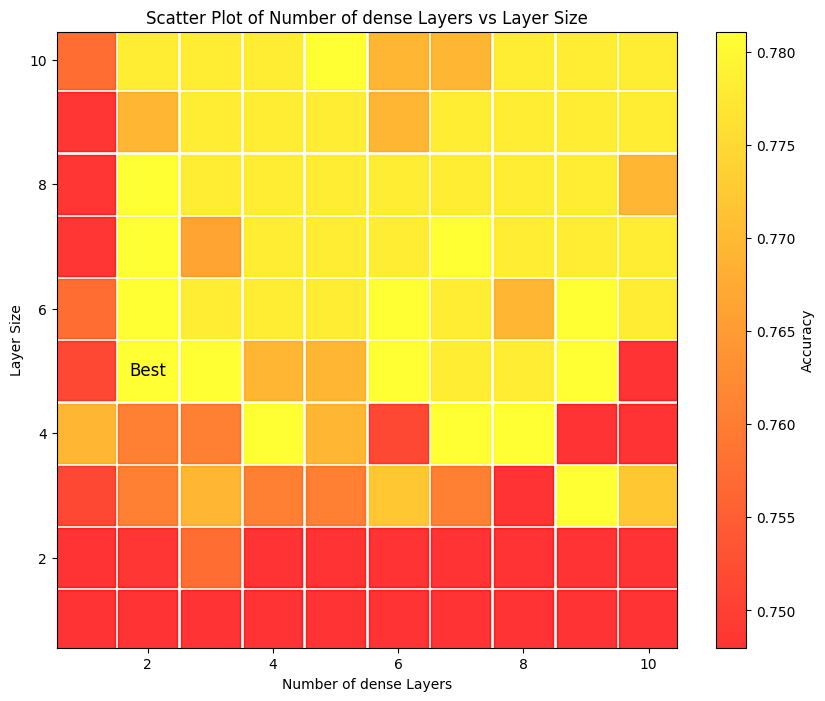

In [43]:
import pickle

with open('df_grid_results_dynamic.pkl', 'rb') as f:
    df_grid_results = pickle.load(f)

# Create scatter plot
plt.figure(figsize=(10, 8))
vmax = df_grid_results['Accuracy'].max()
plt.scatter(df_grid_results['Layers']+1, df_grid_results['Layer Size'], c=df_grid_results['Accuracy'], cmap='autumn', alpha=0.8, vmax=vmax, vmin=0.748, s=1800, marker = 's')

# Add color bar
plt.colorbar(label='Accuracy')

plt.text(2, 5, 'Best', color='black', fontsize=12, ha='center', va='center')

# Set labels and title
plt.xlabel('Number of dense Layers')
plt.ylabel('Layer Size')
plt.title('Scatter Plot of Number of dense Layers vs Layer Size')

# Show plot
plt.show()

### Average Comparisons

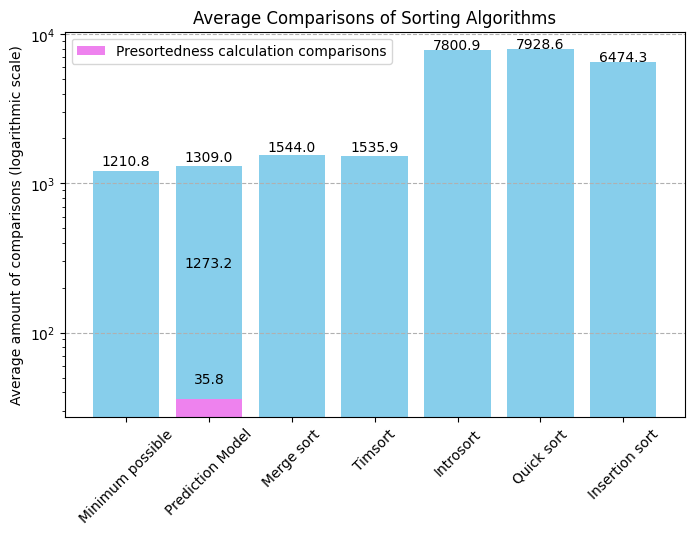

Minimum possible:  1210.8
Algorithm predicting model:  1273.2
Presortedness calculation comparisons:  35.8
Combined comparisons model:  1309.0


Merge sort:  1544.0
Timsort:  1535.9
Introsort:  7800.9
Quick sort:  7928.6
Insertion sort:  6474.3
Selection sort:  19900.0


In [4]:
test_set_df = df_results.iloc[test_indices]
test_set_df.reset_index(drop=True, inplace=True)

c = []
t = []

for index, row in test_set_df.iterrows():
    c.append(row[predicted_algorithms[index]])
    t.append(row[true_algorithms[index]])

def calculate_average(column_name):
    return round(np.sum(test_set_df[column_name]) / len(test_set_df), 1)

minimum_possible = round(np.sum(t)/len(test_set_df), 1)
algorithm_prediction_model = round(np.sum(c)/len(test_set_df), 1)

#inv_dis_comp_dist_avg = calculate_average('inv_dis_comp')

deletions_comp_dist_avg = calculate_average('deletions_comp_dist13')
runs_comp_dist_avg = calculate_average('runs_comp_dist13')

# 
presortedness_average_comp = runs_comp_dist_avg + deletions_comp_dist_avg

merge_sort_avg = calculate_average('merge_sort')
timsort_avg = calculate_average('timsort')
introsort_avg = calculate_average('introsort')
quick_sort_avg = calculate_average('quick_sort')
insertion_sort_avg = calculate_average('insertion_sort')
selection_sort_avg = calculate_average('selection_sort')



data = {
    'Algorithm': ['Minimum possible', 'Prediction Model', 'Merge sort', 'Timsort', 'Introsort', 'Quick sort', 'Insertion sort'],
    'Average Value': [minimum_possible, round(algorithm_prediction_model + presortedness_average_comp, 1), merge_sort_avg, timsort_avg, introsort_avg, quick_sort_avg, insertion_sort_avg]
}
df_average_comp = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 5))

plt.bar(df_average_comp['Algorithm'], df_average_comp['Average Value'], color='skyblue')
plt.bar(df_average_comp['Algorithm'], [0, presortedness_average_comp, 0, 0, 0, 0, 0] , color='violet', label = 'Presortedness calculation comparisons')


plt.title('Average Comparisons of Sorting Algorithms')

for i, val in enumerate(df_average_comp['Average Value']):
    plt.text(i, val + 100, str(val), ha='center')

plt.text(1, presortedness_average_comp + 10, str(presortedness_average_comp), ha='center')
plt.text(1, algorithm_prediction_model - 1000, str(algorithm_prediction_model), ha='center')

plt.ylabel('Average amount of comparisons (logarithmic scale)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

print('Minimum possible: ', minimum_possible)
print('Algorithm predicting model: ', algorithm_prediction_model)
print('Presortedness calculation comparisons: ', presortedness_average_comp)
print('Combined comparisons model: ', round(algorithm_prediction_model + presortedness_average_comp, 1))
print('\n')
print('Merge sort: ', merge_sort_avg)
print('Timsort: ', timsort_avg)
print('Introsort: ', introsort_avg)
print('Quick sort: ', quick_sort_avg)
print('Insertion sort: ', insertion_sort_avg)
print('Selection sort: ', selection_sort_avg)

### Sample size Analysis (rem(X), runs(X))

with param_grid: 
{'batch_size': [250, 500], 'epochs': [250, 500], 'layers': [4, 8], 'layersize': [16, 64]}


,accuracy,sort_comparisons,presortedness_comparisons,combined
0,0.4656,1544.0,0.0,1544.0
1,0.4656,1544.0,2.3,1546.3
2,0.5121,3096.4,4.7,3101.1
3,0.5986,2107.2,7.4,2114.6
4,0.6319,1571.5,10.1,1581.6
5,0.6651,1508.8,13.0,1521.8
6,0.7117,1394.3,16.1,1410.4
7,0.7139,1382.3,19.2,1401.5
8,0.7050,1364.2,22.4,1386.6
9,0.7317,1323.2,25.8,1349.0


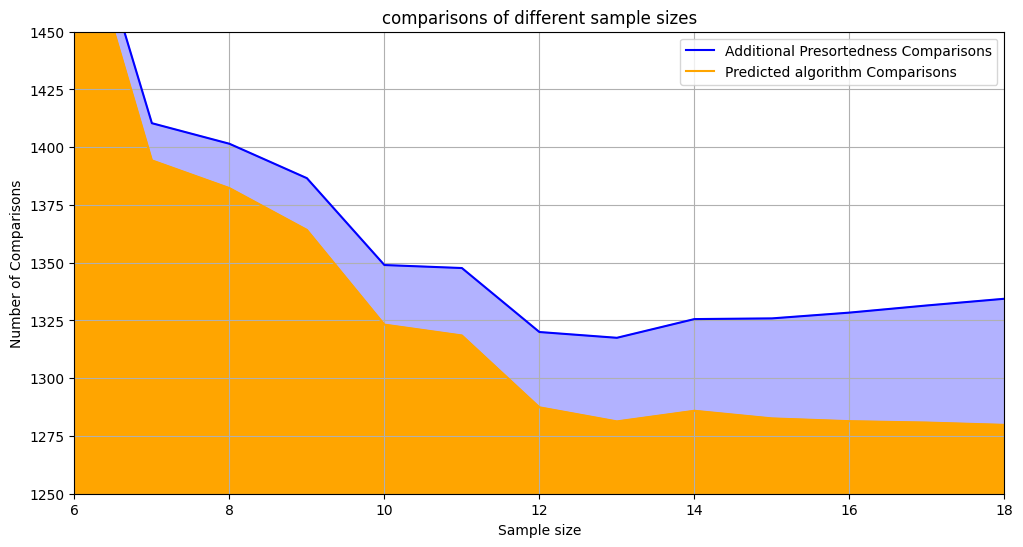

In [5]:
data = [
    {
        'accuracy': 0.4656,
        'sort_comparisons': 1544.0,
        'presortedness_comparisons': 0,
        'combined': 1544.0
    },
    {
        'accuracy': 0.4656,
        'sort_comparisons': 1544.0,
        'presortedness_comparisons': 2.3,
        'combined': 1546.3
    },
    {
        'accuracy': 0.5121,
        'sort_comparisons': 3096.4,
        'presortedness_comparisons': 4.7,
        'combined': 3101.1
    },
    {
        'accuracy': 0.5986,
        'sort_comparisons': 2107.2,
        'presortedness_comparisons': 7.4,
        'combined': 2114.6
    },
    {
        'accuracy': 0.6319,
        'sort_comparisons': 1571.5,
        'presortedness_comparisons': 10.1,
        'combined': 1581.6
    },
    {
        'accuracy': 0.6651,
        'sort_comparisons': 1508.8,
        'presortedness_comparisons': 13.0,
        'combined': 1521.8
    },
    {
        'accuracy': 0.7117,
        'sort_comparisons': 1394.3,
        'presortedness_comparisons': 16.1,
        'combined': 1410.4
    },
    {
        'accuracy': 0.7139,
        'sort_comparisons': 1382.3,
        'presortedness_comparisons': 19.2,
        'combined': 1401.5
    },
    {
        'accuracy': 0.7050,
        'sort_comparisons': 1364.2,
        'presortedness_comparisons': 22.4,
        'combined': 1386.6
    },
    {
        'accuracy': 0.7317,
        'sort_comparisons': 1323.2,
        'presortedness_comparisons': 25.8,
        'combined': 1349.0
    },
    {
        'accuracy': 0.7516,
        'sort_comparisons': 1318.5,
        'presortedness_comparisons': 29.2,
        'combined': 1347.7
    },
    {
        'accuracy': 0.7694,
        'sort_comparisons': 1287.4,
        'presortedness_comparisons': 32.6,
        'combined': 1320.0
    },
    {
        'accuracy': 0.7738,
        'sort_comparisons': 1281.3,
        'presortedness_comparisons': 36.2,
        'combined': 1317.5
    },
    {
        'accuracy': 0.7605,
        'sort_comparisons': 1285.9,
        'presortedness_comparisons': 39.7,
        'combined': 1325.6
    },
    {
        'accuracy': 0.7605,
        'sort_comparisons': 1282.6,
        'presortedness_comparisons': 43.3,
        'combined': 1325.9
    },
    {
        'accuracy': 0.7583,
        'sort_comparisons': 1281.4,
        'presortedness_comparisons': 47.0,
        'combined': 1328.4
    },
    {
        'accuracy': 0.7671,
        'sort_comparisons': 1280.8,
        'presortedness_comparisons': 50.7,
        'combined': 1331.5
    },
    {
        'accuracy': 0.7782,
        'sort_comparisons': 1279.8,
        'presortedness_comparisons': 54.6,
        'combined': 1334.4
    },
    {
        'accuracy': 0.7782,
        'sort_comparisons': 1274.3,
        'presortedness_comparisons': 58.4,
        'combined': 1332.7
    },
    {
        'accuracy': 0.7827,
        'sort_comparisons': 1271.6,
        'presortedness_comparisons': 62.2,
        'combined': 1333.8
    },
]

# Create the DataFrame
df = pd.DataFrame(data)

param_grid = {
    'batch_size': [250,500],
    'epochs': [250,500],
    'layers': [4,8],
    'layersize': [16, 64]
}

print("with param_grid: ")
print(param_grid)

# Display the DataFrame
display(df)


# Plotting
plt.figure(figsize=(12, 6))

# Density plot for 'combined'
plt.plot(df.index + 1, df['combined'], label='Additional Presortedness Comparisons', color='blue')
plt.fill_between(df.index + 1, df['combined'], color='blue', alpha=0.3)

# Density plot for 'presortedness_comparisons'
plt.plot(df.index + 1, df['combined'] - df['presortedness_comparisons'], label='Predicted algorithm Comparisons', color='orange')
plt.fill_between(df.index + 1, df['combined'] - df['presortedness_comparisons'], color='orange')

# Labels and legend
plt.grid()
plt.ylim(1250,1450)
plt.xlim(6,18)
plt.xlabel('Sample size')
plt.ylabel('Number of Comparisons')
plt.title('comparisons of different sample sizes')
plt.legend()

# Show plot
plt.show()

### Presortedness combinations table

In [6]:
data = [
    {
        'presortedness_combinations': 'inv_dis',
        'accuracy': 0.6851,
        'sort_comparisons': 1316.8,
        'presortedness_comparisons': 45,
        'combined': 1361.8
    },
    {
        'presortedness_combinations': 'runs_rem',
        'accuracy': 0.6917,
        'sort_comparisons': 1313.3,
        'presortedness_comparisons': 26.1,
        'combined': 1339.4
    },
    {
        'presortedness_combinations': 'inv_dis_runs',
        'accuracy': 0.7161,
        'sort_comparisons': 1310.5,
        'presortedness_comparisons': 54.0,
        'combined': 1364.5
    },
    {
        'presortedness_combinations': 'inv_dis_rem',
        'accuracy': 0.6917,
        'sort_comparisons': 1312.7,
        'presortedness_comparisons': 62.1,
        'combined': 1374.8
    },
    {
        'presortedness_combinations': 'inv_dis_runs_rem',
        'accuracy': 0.7228,
        'sort_comparisons': 1306.4,
        'presortedness_comparisons': 71.1,
        'combined': 1377.5
    },
    # Add more dictionaries as needed
]

# Create the DataFrame
df = pd.DataFrame(data)

param_grid = {
    'batch_size': [250,500],
    'epochs': [250,500],
    'layers': [4,8],
    'layersize': [16, 64]
}

print("with param_grid: ")
print(param_grid)

# Display the DataFrame
display(df)

with param_grid: 
{'batch_size': [250, 500], 'epochs': [250, 500], 'layers': [4, 8], 'layersize': [16, 64]}


,presortedness_combinations,accuracy,sort_comparisons,presortedness_comparisons,combined
0,inv_dis,0.6851,1316.8,45.0,1361.8
1,runs_rem,0.6917,1313.3,26.1,1339.4
2,inv_dis_runs,0.7161,1310.5,54.0,1364.5
3,inv_dis_rem,0.6917,1312.7,62.1,1374.8
4,inv_dis_runs_rem,0.7228,1306.4,71.1,1377.5


### Model analysis

In [7]:
from itertools import product

# Generate arrays with combinations of values
def generate_arrays(values, n):
    return [list(comb) for comb in product(values, repeat=n)]

possible_values = [100, 25, 10 , 5, 1, 0]
X_analysis = generate_arrays(possible_values, 2)

X_analysis_scaled = scaler.fit_transform(X_analysis)

y_preds = model.predict(X_analysis_scaled)
y_preds_classes = np.argmax(y_preds, axis=1)
predicted_algorithm = label_encoder.inverse_transform(y_preds_classes)

print(predicted_algorithm)

2/2 [==============================] - 0s 7ms/step
['merge_sort' 'timsort' 'timsort' 'timsort' 'timsort' 'timsort'
 'merge_sort' 'merge_sort' 'timsort' 'timsort' 'timsort' 'timsort'
 'merge_sort' 'merge_sort' 'timsort' 'timsort' 'timsort' 'timsort'
 'merge_sort' 'merge_sort' 'timsort' 'timsort' 'timsort' 'timsort'
 'merge_sort' 'timsort' 'timsort' 'timsort' 'timsort' 'timsort'
 'merge_sort' 'timsort' 'timsort' 'timsort' 'timsort' 'timsort']
